In [1]:
from requests import get
from json import dumps
import json
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import numpy as np
import datetime
import pyswarms as ps
from pyswarms.single.global_best import GlobalBestPSO
import seaborn as sns
from tqdm import tqdm
from scipy.ndimage import center_of_mass

In [2]:
cases_admiss = {}
admiss_occup = {}

In [3]:
# download api data
req = "https://api.coronavirus.data.gov.uk/v2/data?areaType=nation&areaCode=E92000001&metric=hospitalCases&metric=newAdmissions&metric=newCasesBySpecimenDate&format=json" #&release=2021-06-02"
response = get(req, timeout=10)
if response.status_code >= 400:
    raise RuntimeError(f'Request failed: { response.text }')
response = response.json()

df = pd.DataFrame(response['body'])
df['dateTime'] = pd.to_datetime(df['date'])
df.sort_values(by=['dateTime'], inplace=True)
df.dropna(inplace=True)

x_dateTimes = sorted(list(set(df.dateTime.to_list())))
top_date = x_dateTimes[-1].strftime("%Y-%m-%d")
print(top_date)

2021-06-23


In [14]:
waves = [
    {"start":"2020-08-01", "end":top_date},    
    {},
    {"start":"2020-11-01", "end":"2021-03-01"},    
    {"start":"2020-11-01", "end":top_date}
]

wave = 3
start_date = waves[wave]["start"]
end_date = waves[wave]["end"]

_df = df[(df.dateTime >= start_date) & (df.dateTime <= end_date)]
cases_stream = np.array(_df.newCasesBySpecimenDate.to_list(), dtype=int)
admissions_stream = np.array(_df.newAdmissions.to_list(), dtype=int)
occupancy_stream = np.array(_df.hospitalCases.to_list(), dtype=int)
#occupancy_stream -= occupancy_stream[0]

def N_avg(a, N=7):
    # weekly avg into the past
    b = np.zeros(len(a)-N)
    for i in range(N,len(a),1):
        b[i-N] = np.mean(a[i-N:i])
    return b

#cases_stream = N_avg(cases_stream)
#admissions_stream = N_avg(admissions_stream)
#occupancy_stream = N_avg(occupancy_stream)

print(cases_stream)
print(admissions_stream)
print(occupancy_stream)
print(len(occupancy_stream))

[13367 27923 22307 20690 20875 20826 16620 17961 28097 24468 24643 21947
 21653 16037 14210 23731 20322 18213 15502 14676 10615 10036 16207 14030
 13935 12281 12263  9206  8908 15029 13516 13468 12527 12881 10145 10871
 17392 16675 17461 18543 19867 16029 18128 29516 29098 30123 29595 31829
 21736 28941 42592 40903 37615 28701 12675 36701 42442 40040 72510 62894
 46680 28222 54163 49517 69108 58037 51313 46829 42327 35442 32855 52000
 44673 41152 38518 36789 27654 26206 40721 35968 31758 28760 26908 19874
 15456 27106 24434 23237 21846 19680 15001 13704 20110 17656 17411 16149
 13973 10583 10132 13836 12241 11839 11223 10563  7740  7533 12467 10816
 10023  9904  8882  6890  6799  9856  8141  7291  6609  5666  4104  3953
  5888  5684  5095  4790  4552  3702  3528  5564  5211  5007  4686  4614
  3449  3583  5437  4740  4852  4522  4138  3367  4516  5142  4336  5107
  4443  3620  2942  4093  3202  2953  3141  2864  2126  2016  1925  2188
  2560  2585  2478  2313  1890  1896  2234  1906  1

In [5]:
def _f(x, in_stream, out_stream):
    # model out_stream as a convolution of in_stream with x
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def f(xs, in_stream=cases_stream, out_stream=admissions_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _f(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret        

In [6]:
n_dim = 30
n_particles = 1000

x_max = 0.1*np.ones(n_dim)
x_min = np.zeros(n_dim)
options = {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
bounds = (x_min, x_max)
init_pos = np.array([x_min for i in range(n_particles)])

cases_admiss_outputs = []

In [7]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(f, 1000, verbose=True, n_processes=10)
    cases_admiss_outputs.append(pos)
cases_admiss_outputs = np.array(cases_admiss_outputs)

2021-06-26 07:32:52,580 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=134 
2021-06-26 07:32:57,489 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 133.8144164635513, best pos: [0.0184512  0.00562194 0.00135774 0.00636935 0.00482557 0.00245272
 0.00285663 0.00248401 0.00329543 0.00225939 0.00224694 0.00202992
 0.00246701 0.00212576 0.00294541 0.00270102 0.00236761 0.00146653
 0.00377903 0.00181806 0.00175929 0.00073525 0.00171293 0.00146383
 0.00065028 0.00052255 0.00091006 0.00082729 0.00082378 0.00214307]
2021-06-26 07:32:57,496 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=136 
2021-06-26 07:33:02,398 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 135.62641118912862, best pos: [0.01091776 0.012

2021-06-26 07:33:54,715 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=134 
2021-06-26 07:33:59,315 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 134.44186435054192, best pos: [0.01151045 0.00893247 0.00460172 0.00248176 0.00431755 0.00536824
 0.00395269 0.00250598 0.00356004 0.00299456 0.00446518 0.00124486
 0.00305179 0.00222817 0.00310129 0.00174526 0.00167519 0.0007739
 0.00144457 0.00090915 0.00298742 0.0010999  0.00184858 0.00065808
 0.00165472 0.00240267 0.0010039  0.00111822 0.00147239 0.00106573]
2021-06-26 07:33:59,322 - pyswarms.single.global_best - INFO - Optimize for 1000 iters with {'c1': 0.1, 'c2': 0.1, 'w': 0.5}
pyswarms.single.global_best: 100%|██████████|1000/1000, best_cost=136 
2021-06-26 07:34:03,968 - pyswarms.single.global_best - INFO - Optimization finished | best cost: 135.97199502518922, best pos: [0.01465131 0.008

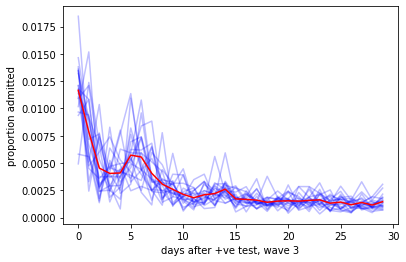

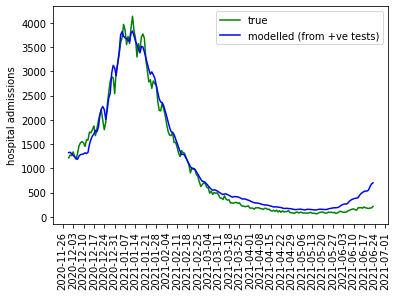

In [15]:
plt.clf()
x = list(range(len(pos)))
for y in cases_admiss_outputs:
    #print(sum(y))
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg_cases_admiss = []
for i in range(len(y)):
    y_avg_cases_admiss.append(np.mean(cases_admiss_outputs[:,i]))
plt.plot(x, y_avg_cases_admiss, color="red", alpha=1)
plt.xlabel("days after +ve test, wave %d" % wave)
plt.ylabel("proportion admitted")
plt.savefig("cases_admiss_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _f(y_avg_cases_admiss, cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled (from +ve tests)")
#plt.xlabel("days after start of wave %d" % wave)
plt.ylabel("hospital admissions")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()


cases_admiss[wave] = y_avg_cases_admiss

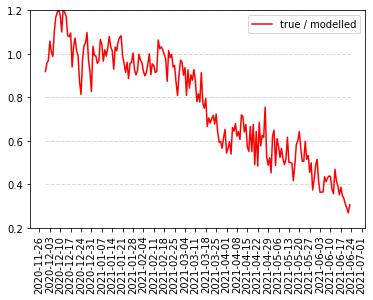

0.30575581732751717


In [18]:
plt.clf()
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="true / modelled")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.2,1.2)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("cases_admiss_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

print((true/pred)[-1])

2 0.08593502220939857 (9.200438942142902,)


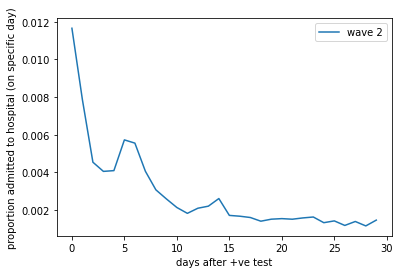

In [13]:
for wave,y_avg_cases_admiss in cases_admiss.items():
    print(wave, np.sum(y_avg_cases_admiss), center_of_mass(np.array(y_avg_cases_admiss)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_cases_admiss in cases_admiss.items():
    plt.plot(x, y_avg_cases_admiss, label="wave %d" % wave)
plt.xlabel("days after +ve test")
plt.ylabel("proportion admitted to hospital (on specific day)")
plt.legend()
plt.savefig("cases_admiss_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

In [ ]:
x_dateTimes = df.dateTime.to_list()[-len(x)-11:]

y = {}
admiss_rolling = {}
cases_rolling = {}
for n in [14,12,10,8,6,4]:
    _y1 = []
    _y2 = []
    _y = []
    for dateTime in x_dateTimes[n+7:]:
        dateTime1 = dateTime - datetime.timedelta(days=8)
        dateTime2 = dateTime 
        y1 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newAdmissions.to_list())
        _y1.append(y1/7)
        dateTime1 = dateTime1 - datetime.timedelta(days=n)
        dateTime2 = dateTime2 - datetime.timedelta(days=n)
        y2 = np.sum(df[(df.dateTime<=dateTime2) & (df.dateTime>dateTime1)].newCasesBySpecimenDate.to_list())
        _y2.append(y2/7)
        _y.append(y1/y2)
    y[n] = np.array(_y)
    admiss_rolling[n] = np.array(_y1)
    cases_rolling[n] = np.array(_y2)

plt.clf()
plt.title("admissions as % of +ve tests n days before, weekly rolling avgs")
for n,_y in y.items():
    plt.plot(x_dateTimes[n+7:], _y*100, label="n=%d" % n)
true, pred = _f(cases_admiss[2], cases_stream, admissions_stream) 
plt.xticks(rotation=90)
plt.gca().xaxis.set_major_locator(plt.MultipleLocator(7))
#plt.ylim(2,None)
plt.legend()
plt.savefig("test_vs_admiss_n_days_ago", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()



In [ ]:
def _g(x, in_stream, out_stream):
    # model each 1 from in_stream as remaining present for a period with distribution x, in out_stream
    target_out_stream = out_stream[len(x)-1:]
    pred_out_stream = np.convolve(in_stream, x, mode="valid")
    return target_out_stream, pred_out_stream

def g(xs, in_stream=admissions_stream, out_stream=occupancy_stream):
    ret = np.zeros(np.shape(xs)[0])
    for i in range(len(ret)):
        x = xs[i,:]
        target_out_stream, pred_out_stream = _g(x, in_stream, out_stream)
        ret[i] = np.sum(np.abs(pred_out_stream - target_out_stream)) / len(pred_out_stream)
    return ret    

print(_g(np.array([0.5,0.5]), [1,1,1,3,3,3], [0,1,2,3,4,5]))

In [ ]:
n_dim = 30
n_particles = 1000

x_max = np.ones(n_dim)
x_max[0:3] = [1.1,1.1,1.1]
x_min = -0.1*np.ones(n_dim)
options = {'c1': 0.6, 'c2': 0.3, 'w': 0.90}
bounds = (x_min, x_max)
init_pos = None#np.array([x_min for i in range(n_particles)])

admiss_occup_outputs = []

In [ ]:
for i in range(20):
    optimizer = GlobalBestPSO(n_particles=n_particles, dimensions=n_dim, options=options, bounds=bounds, init_pos=init_pos)
    cost, pos = optimizer.optimize(g, 1000, verbose=True, n_processes=11)
    admiss_occup_outputs.append(pos)
admiss_occup_outputs = np.array(admiss_occup_outputs)

In [ ]:
plt.clf()
x = list(range(len(pos)))
for y in admiss_occup_outputs:
    plt.plot(x, y, color="blue", alpha=0.25)
y_avg_admiss_occup = []
for i in range(len(y)):
    y_avg_admiss_occup.append(np.mean(admiss_occup_outputs[:,i]))
plt.plot(x, y_avg_admiss_occup, color="red", alpha=1)
plt.xlabel("days after admission, wave %d" % wave)
plt.ylabel("proportion still in hospital (est.)")
plt.savefig("admiss_occup_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

plt.clf()
true, pred = _g(np.array(y_avg_admiss_occup), admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true, color="green", label="true")
plt.plot(x, pred, color="blue", label="modelled")
plt.ylabel("hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

admiss_occup[wave] = y_avg_admiss_occup

In [ ]:
plt.clf()
true, pred = _g(y_avg_admiss_occup, admissions_stream, occupancy_stream) 
x = _df.dateTime.to_list()[-len(true):]
plt.plot(x, true/pred, color="red", label="[true / modelled] hospital occupancy")
plt.legend()
plt.xticks(rotation=90)
ax = plt.gca()
ax.xaxis.set_major_locator(ticker.MultipleLocator(7))
plt.ylim(0.6,None)
y_locs,_ = plt.yticks()
plt.hlines(y_locs, x[0], x[-1], color="black", linestyles='dashed', alpha=0.15, linewidth=1)
plt.savefig("admiss_occup_pred_wave%d.png" % wave, bbox_inches='tight', facecolor='white', transparent=False)
plt.show()

In [ ]:
for wave,y_avg_admiss_occup in admiss_occup.items():
    print(wave, np.sum(y_avg_admiss_occup), center_of_mass(np.array(y_avg)))
          
plt.clf()
x = range(n_dim)
for wave,y_avg_admiss_occup in admiss_occup.items():
    plt.plot(x, y_avg, label="wave %d" % wave)
plt.xlabel("days after admission")
plt.ylabel("proportion still in hospital")
plt.legend()
plt.savefig("admiss_occup_compare.png", bbox_inches='tight', facecolor='white', transparent=False)
plt.show()